# Ranges of Similar Variables

In [1]:
# NOTE: This notebook uses the polars package
import numpy as np

from plotnine import *
import polars as pl
from polars import col

### Ranges of Similar Variables

*Comparing the point to point difference of many similar variables*

Read the data.

Source: Pew Research Global Attitudes Spring 2015

In [2]:
!head -n 20 "data/survey-social-media.csv"

PSRAID,COUNTRY,Q145,Q146,Q70,Q74
100000,Ethiopia,Female,35,No, 
100001,Ethiopia,Female,25,No, 
100002,Ethiopia,Male,40,Don’t know, 
100003,Ethiopia,Female,30,Don’t know, 
100004,Ethiopia,Male,22,No, 
100005,Ethiopia,Male,40,No, 
100006,Ethiopia,Female,20,No, 
100007,Ethiopia,Female,18,No,No
100008,Ethiopia,Male,50,No, 
100009,Ethiopia,Male,35,No, 
100010,Ethiopia,Female,20,No, 
100011,Ethiopia,Female,30,Don’t know, 
100012,Ethiopia,Male,60,No, 
100013,Ethiopia,Male,18,No, 
100014,Ethiopia,Male,40,No, 
100015,Ethiopia,Male,28,Don’t know, 
100016,Ethiopia,Female,55,Don’t know, 
100017,Ethiopia,Male,30,Don’t know, 
100018,Ethiopia,Female,22,No, 

In [3]:
columns = dict(
    COUNTRY="country",
    Q145="gender",
    Q146="age",
    Q70="use_internet",
    Q74="use_social_media",
)

data = (
    pl.scan_csv(
        "data/survey-social-media.csv",
        dtypes=dict(Q146=pl.Utf8),
    )
    .rename(columns)
    .select(["country", "age", "use_social_media"])
    .collect()
)

data.sample(10, seed=123)

Create age groups for users of social media

In [4]:
yes_no = ["Yes", "No"]
valid_age_groups = ["18-34", "35-49", "50+"]

rdata = (
    data.with_columns(
        age_group=pl.when(col("age") <= "34")
        .then(pl.lit("18-34"))
        .when(col("age") <= "49")
        .then(pl.lit("35-49"))
        .when(col("age") < "98")
        .then(pl.lit("50+"))
        .otherwise(pl.lit("")),
        country_count=pl.count().over("country"),
    )
    .filter(
        col("age_group").is_in(valid_age_groups) & col("use_social_media").is_in(yes_no)
    )
    .group_by(["country", "age_group"])
    .agg(
        # social media use percentage
        sm_use_percent=(col("use_social_media") == "Yes").sum() * 100 / pl.count(),
        # social media question response rate
        smq_response_rate=col("use_social_media").is_in(yes_no).sum()
        * 100
        / col("country_count").first(),
    )
    .sort(["country", "age_group"])
)

rdata.head()

Top 14 countries by response rate to the social media question.

In [5]:
def col_format(name, fmt):
    # Format useing python formating
    # for more control over
    return col(name).map_elements(lambda x: fmt.format(x=x))


def float_to_str_round(name):
    return col_format(name, "{x:.0f}")


n = 14

top = (
    rdata.group_by("country")
    .agg(r=col("smq_response_rate").sum())
    .sort("r", descending=True)
    .head(n)
)
top_countries = top["country"]

expr = float_to_str_round("sm_use_percent")
expr_pct = expr + "%"

point_data = rdata.filter(col("country").is_in(top_countries)).with_columns(
    col("country").cast(pl.Categorical),
    sm_use_percent_str=pl.when(col("country") == "France")
    .then(expr_pct)
    .otherwise(expr),
)

point_data.head()

In [6]:
segment_data = (
    point_data.group_by("country")
    .agg(
        min=col("sm_use_percent").min(),
        max=col("sm_use_percent").max(),
    )
    .with_columns(gap=(col("max") - col("min")))
    .sort(
        "gap",
    )
    .with_columns(
        min_str=float_to_str_round("min"),
        max_str=float_to_str_round("max"),
        gap_str=float_to_str_round("gap"),
    )
)

segment_data.head()

Format the floating point data that will be plotted into strings

First plot

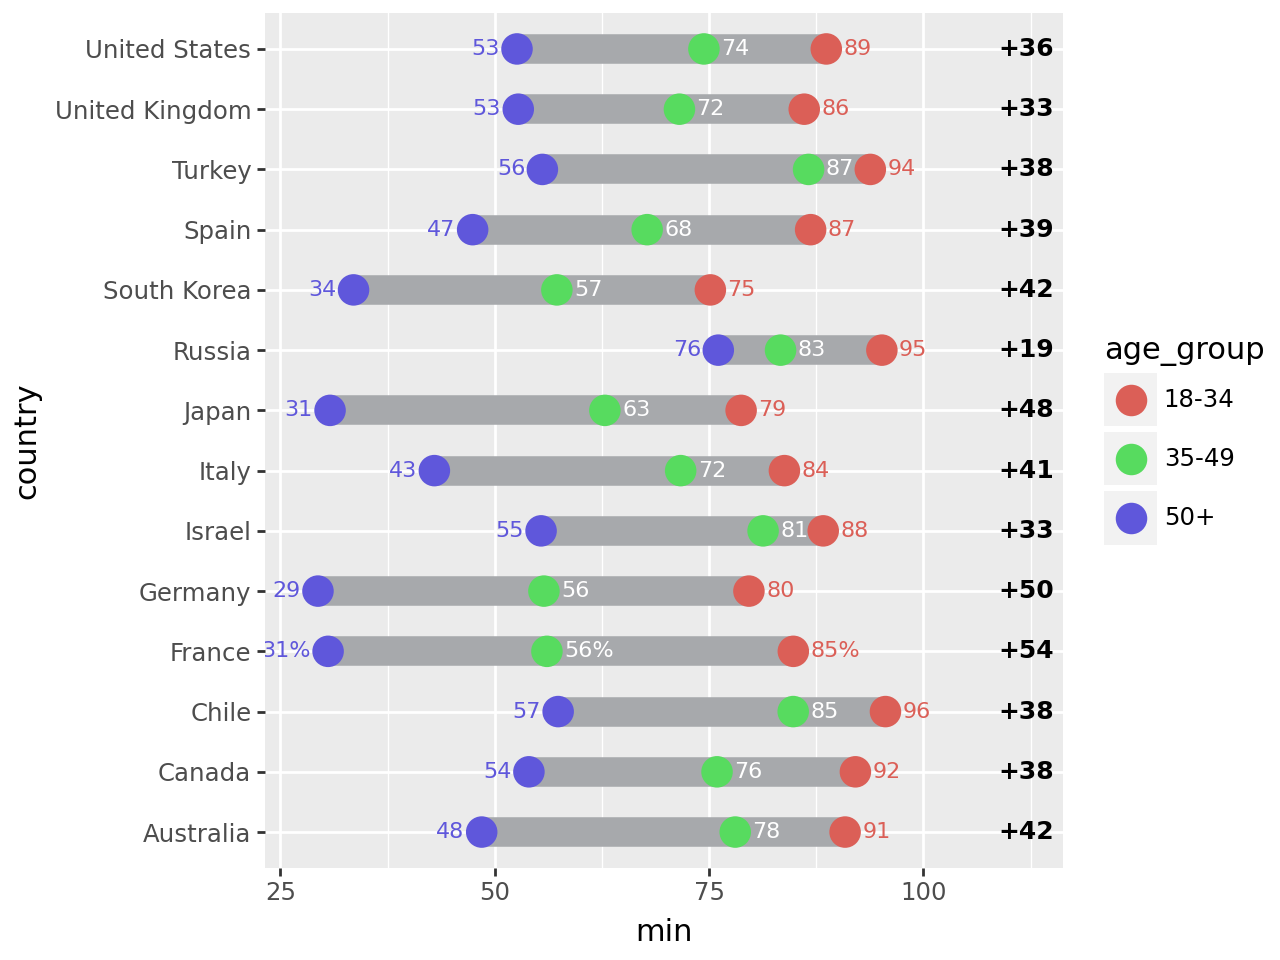

In [7]:
# The right column (youngest-oldest gap) location
xgap = 112

(
    ggplot()
    # Range strip
    + geom_segment(
        segment_data,
        aes(x="min", xend="max", y="country", yend="country"),
        size=6,
        color="#a7a9ac",
    )
    # Age group markers
    + geom_point(
        point_data,
        aes("sm_use_percent", "country", color="age_group", fill="age_group"),
        size=5,
        stroke=0.7,
    )
    # Age group percentages
    + geom_text(
        point_data.filter(col("age_group") == "50+"),
        aes(
            x="sm_use_percent-2",
            y="country",
            label="sm_use_percent_str",
            color="age_group",
        ),
        size=8,
        ha="right",
    )
    + geom_text(
        point_data.filter(col("age_group") == "35-49"),
        aes(x="sm_use_percent+2", y="country", label="sm_use_percent_str"),
        size=8,
        ha="left",
        va="center",
        color="white",
    )
    + geom_text(
        point_data.filter(col("age_group") == "18-34"),
        aes(
            x="sm_use_percent+2",
            y="country",
            label="sm_use_percent_str",
            color="age_group",
        ),
        size=8,
        ha="left",
    )
    # gap difference
    + geom_text(
        segment_data,
        aes(x=xgap, y="country", label="gap_str"),
        size=9,
        fontweight="bold",
        format_string="+{}",
    )
)

Tweak it

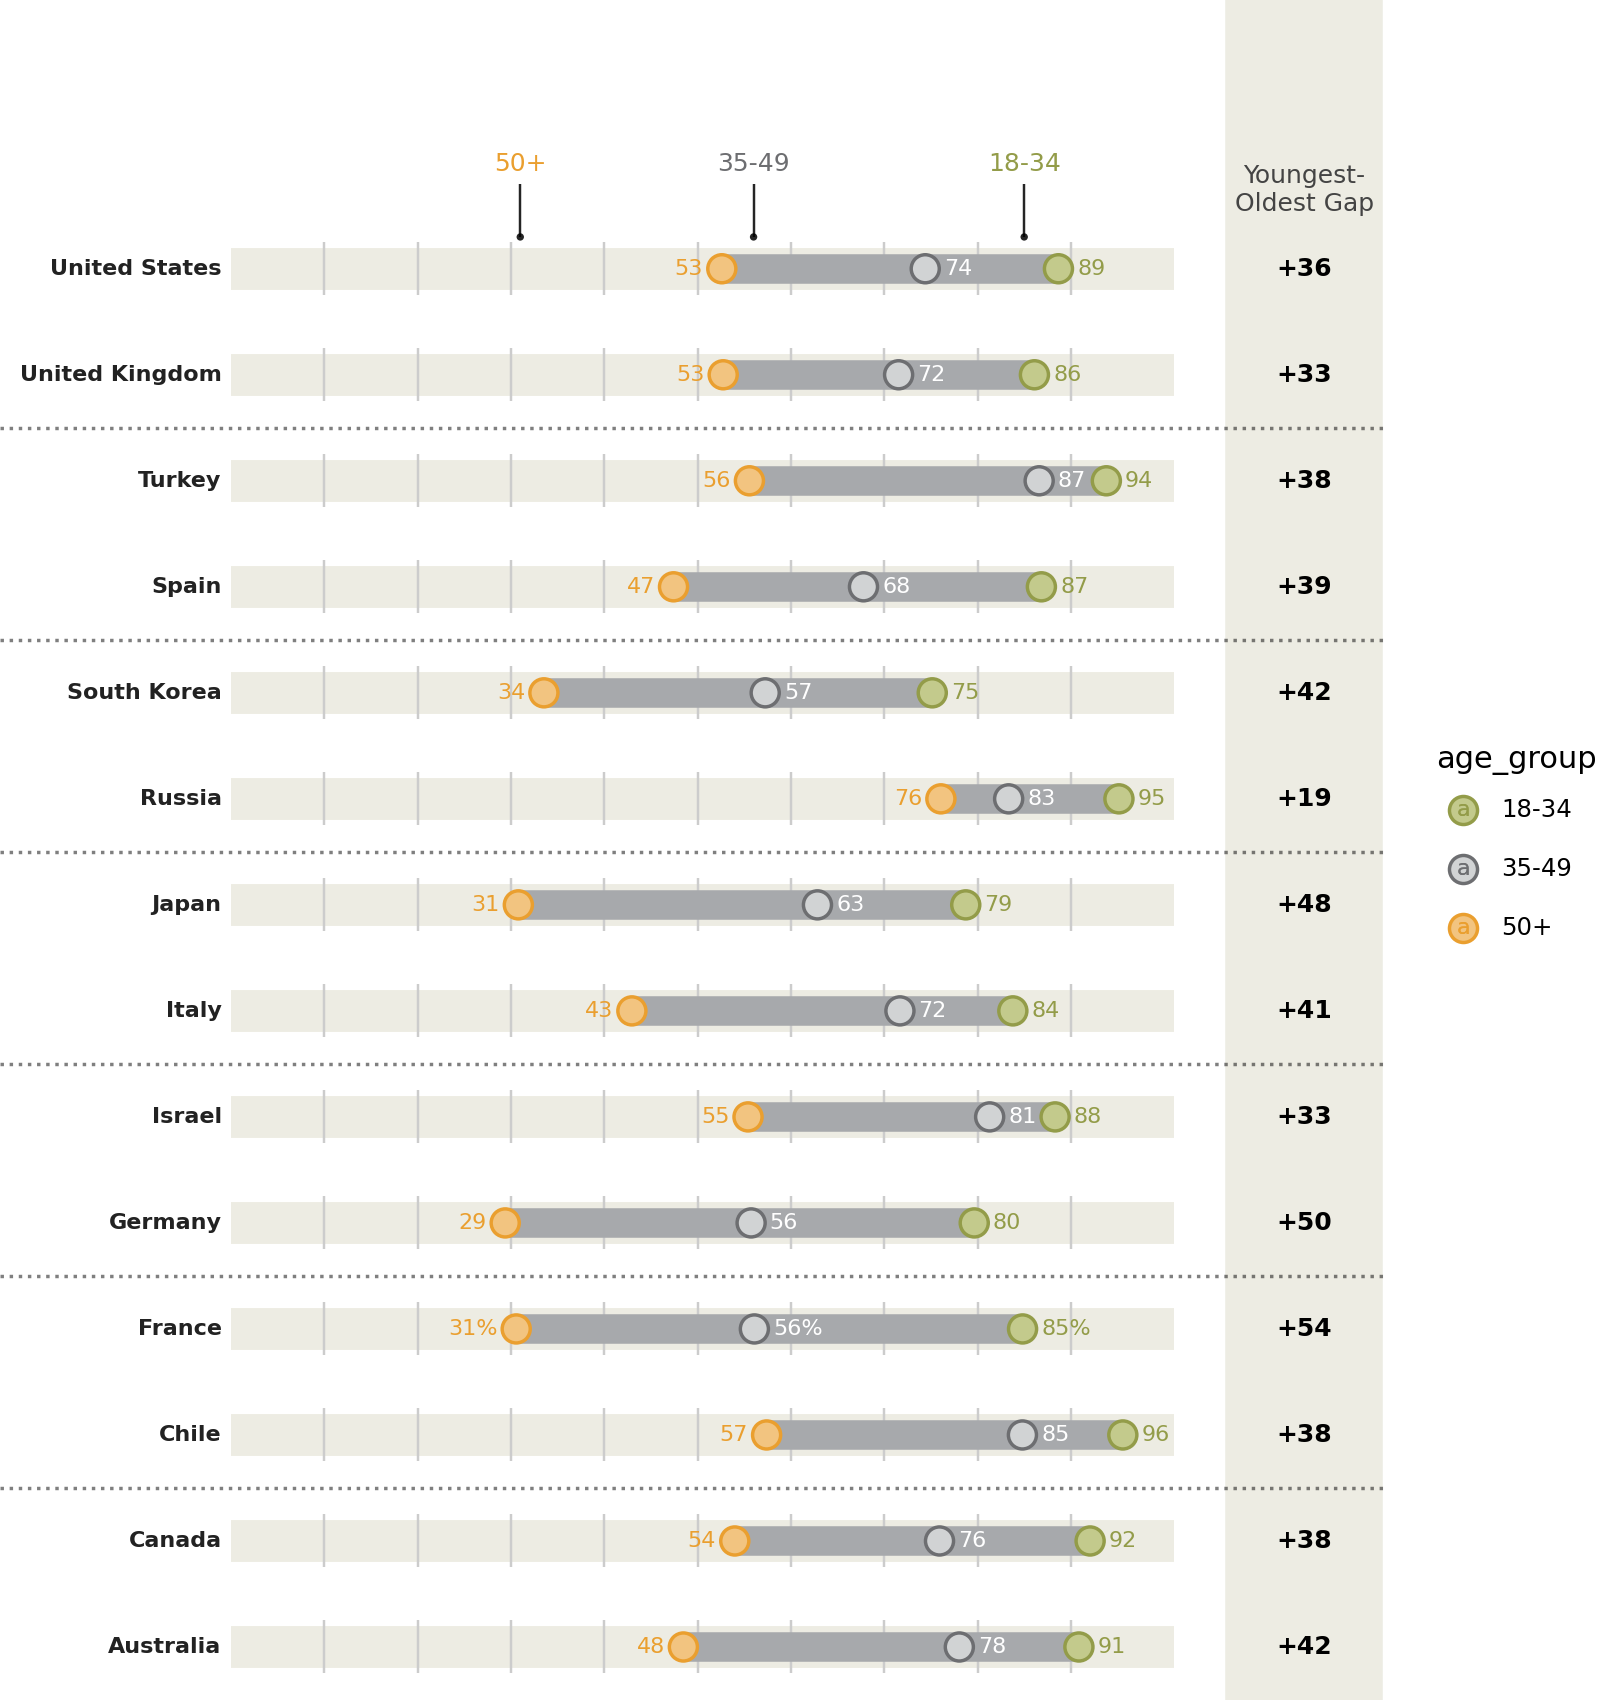

In [8]:
# The right column (youngest-oldest gap) location
xgap = 115

# Gallery Plot

(
    ggplot()
    # Background Strips                                     # new
    + geom_segment(
        segment_data,
        aes(y="country", yend="country"),
        x=0,
        xend=101,
        size=8.5,
        color="#edece3",
    )
    # vertical grid lines along the strips                  # new
    + annotate(
        "segment",
        x=list(range(10, 100, 10)) * n,
        xend=list(range(10, 100, 10)) * n,
        y=np.tile(np.arange(1, n + 1), 9) - 0.25,
        yend=np.tile(np.arange(1, n + 1), 9) + 0.25,
        color="#CCCCCC",
    )
    # Range strip
    + geom_segment(
        segment_data,
        aes(x="min", xend="max", y="country", yend="country"),
        size=6,
        color="#a7a9ac",
    )
    # Age group markers
    + geom_point(
        point_data,
        aes("sm_use_percent", "country", color="age_group", fill="age_group"),
        size=5,
        stroke=0.7,
    )
    # Age group percentages
    + geom_text(
        point_data.filter(col("age_group") == "50+"),
        aes(
            x="sm_use_percent-2",
            y="country",
            label="sm_use_percent_str",
            color="age_group",
        ),
        size=8,
        ha="right",
    )
    + geom_text(
        point_data.filter(col("age_group") == "35-49"),
        aes(x="sm_use_percent+2", y="country", label="sm_use_percent_str"),
        size=8,
        ha="left",
        va="center",
        color="white",
    )
    + geom_text(
        point_data.filter(col("age_group") == "18-34"),
        aes(
            x="sm_use_percent+2",
            y="country",
            label="sm_use_percent_str",
            color="age_group",
        ),
        size=8,
        ha="left",
    )
    # countries right-hand-size (instead of y-axis)         # new
    + geom_text(
        segment_data,
        aes(y="country", label="country"),
        x=-1,
        size=8,
        ha="right",
        fontweight="bold",
        color="#222222",
    )
    # gap difference
    + geom_vline(xintercept=xgap, color="#edece3", size=32)  # new
    + geom_text(
        segment_data,
        aes(x=xgap, y="country", label="gap_str"),
        size=9,
        fontweight="bold",
        format_string="+{}",
    )
    # Annotations                                            # new
    + annotate("text", x=31, y=n + 1.1, label="50+", size=9, color="#ea9f2f", va="top")
    + annotate(
        "text", x=56, y=n + 1.1, label="35-49", size=9, color="#6d6e71", va="top"
    )
    + annotate(
        "text", x=85, y=n + 1.1, label="18-34", size=9, color="#939c49", va="top"
    )
    + annotate(
        "text",
        x=xgap,
        y=n + 0.5,
        label="Youngest-\nOldest Gap",
        size=9,
        color="#444444",
        va="bottom",
        ha="center",
    )
    + annotate("point", x=[31, 56, 85], y=n + 0.3, alpha=0.85, stroke=0)
    + annotate(
        "segment",
        x=[31, 56, 85],
        xend=[31, 56, 85],
        y=n + 0.3,
        yend=n + 0.8,
        alpha=0.85,
    )
    + annotate(
        "hline",
        yintercept=[x + 0.5 for x in range(2, n, 2)],
        alpha=0.5,
        linetype="dotted",
        size=0.7,
    )
    # Better spacing and color                              # new
    + scale_x_continuous(limits=(-18, xgap + 2))
    + scale_y_discrete(expand=(0, 0.25, 0.1, 0))
    + scale_fill_manual(values=["#c3ca8c", "#d1d3d4", "#f2c480"])
    + scale_color_manual(values=["#939c49", "#6d6e71", "#ea9f2f"])
    + guides(color=None, fill=None)
    + theme_void()
    + theme(figure_size=(8, 8.5))
)

Instead of looking at this plot as having a country variable on the
`y-axis` and a percentage variable on the `x-axis`, we can view it as
having vertically stacked up many *indepedent* variables, the values of
which have a similar scale.

**Protip:** Save a pdf file.

### Change in Rank

*Comparing a group of ranked items at two different times*

Read the data.

Source: World Bank - Infanct Mortality Rate (per 1,000 live births)b

In [9]:
data = pl.read_csv(
    "data/API_SP.DYN.IMRT.IN_DS2_en_csv_v2/API_SP.DYN.IMRT.IN_DS2_en_csv_v2.csv",
    skip_rows=4,
    null_values="",
    truncate_ragged_lines=True,
)

# Columns as valid python variables
year_columns = {c: f"y{c}" for c in data.columns if c[:2] in {"19", "20"}}
data = data.rename(
    {"Country Name": "country", "Country Code": "code", **year_columns}
).drop(["Indicator Name", "Indicator Code"])
data.head()

The data includes regional aggregates. To tell apart the regional
aggregates we need the metadata. Every row in the data table has a
corresponding row in the metadata table. Where the row has regional
aggregate data, the `Region` column in the metadata table is `NaN`.

In [10]:
def ordered_categorical(s, categories=None):
    """
    Create a categorical ordered according to the categories
    """
    name = getattr(s, "name", "")
    if categories is None:
        return pl.Series(name, s).cast(pl.Categorical)

    with pl.StringCache():
        pl.Series(categories).cast(pl.Categorical)
        return pl.Series(name, s).cast(pl.Categorical)


columns = {"Country Code": "code", "Region": "region", "IncomeGroup": "income_group"}

metadata = (
    pl.scan_csv(
        "data/API_SP.DYN.IMRT.IN_DS2_en_csv_v2/Metadata_Country_API_SP.DYN.IMRT.IN_DS2_en_csv_v2.csv"
    )
    .rename(columns)
    .select(list(columns.values()))
    .filter(
        # Drop the regional aggregate information
        (col("region") != "") & (col("income_group") != "")
    )
    .collect()
)

cat_order = ["High income", "Upper middle income", "Lower middle income", "Low income"]
metadata = metadata.with_columns(
    ordered_categorical(metadata["income_group"], cat_order)
)

metadata.head(10)

Remove the regional aggregates, to create a table with only country data

In [11]:
country_data = data.join(metadata, on="code")
country_data.head()

We are interested in the changes in rank between 1960 and 2015. To plot
a reasonable sized graph, we randomly sample 35 countries.

In [12]:
sampled_data = (
    country_data.drop_nulls(subset=["y1960", "y2015"])
    .sample(n=35, seed=123)
    .with_columns(
        y1960_rank=col("y1960").rank(method="ordinal").cast(pl.Int64),
        y2015_rank=col("y2015").rank(method="ordinal").cast(pl.Int64),
    )
    .sort("y2015_rank", descending=True)
)

sampled_data.head()

First graph

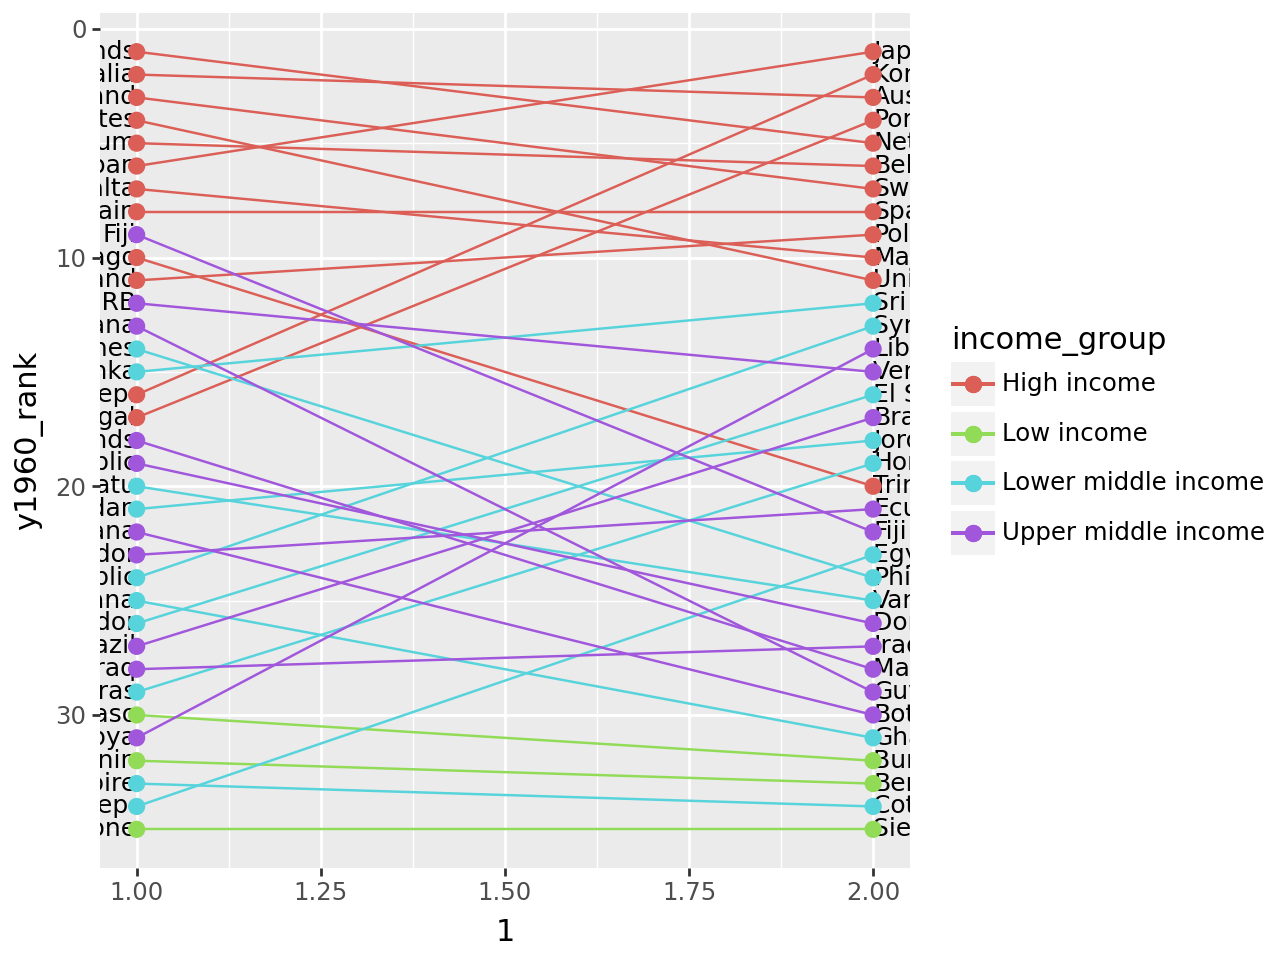

In [13]:
(
    ggplot(sampled_data)
    + geom_text(aes(1, "y1960_rank", label="country"), ha="right", size=9)
    + geom_text(aes(2, "y2015_rank", label="country"), ha="left", size=9)
    + geom_point(aes(1, "y1960_rank", color="income_group"), size=2.5)
    + geom_point(aes(2, "y2015_rank", color="income_group"), size=2.5)
    + geom_segment(
        aes(x=1, y="y1960_rank", xend=2, yend="y2015_rank", color="income_group")
    )
    + scale_y_reverse()
)

It has the form we want, but we need to tweak it.

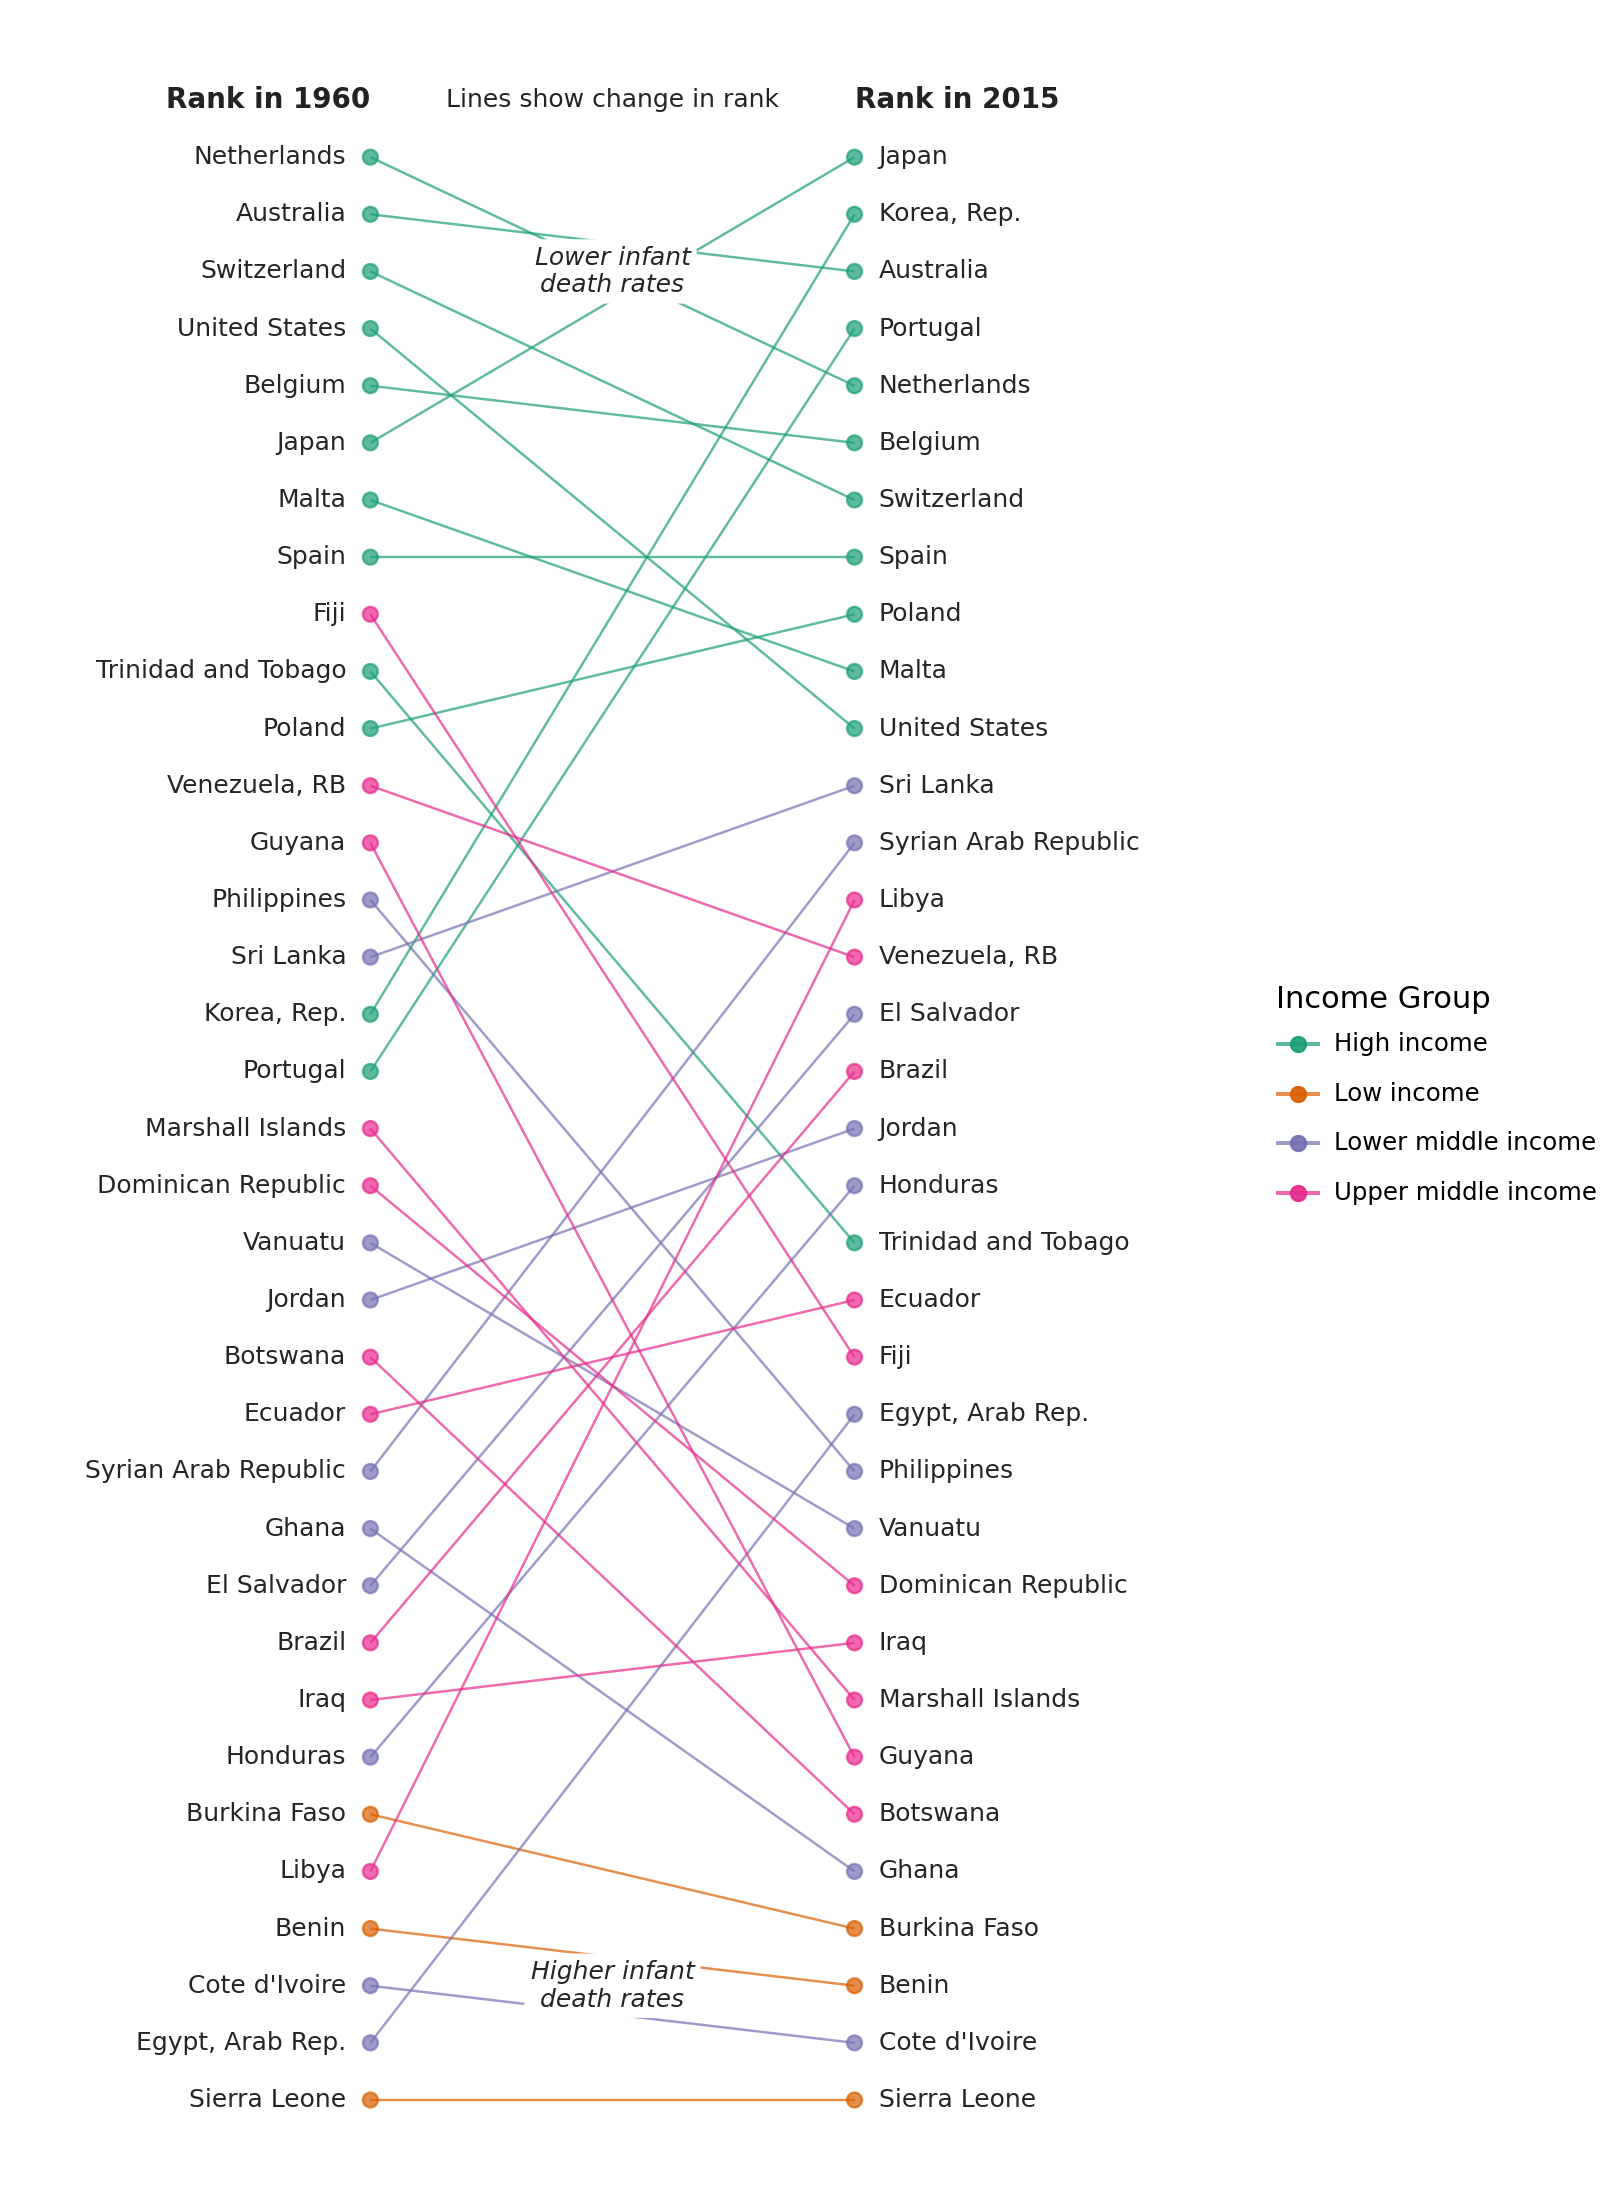

In [14]:
# Text colors
black1 = "#252525"
black2 = "#222222"

# Gallery Plot

(
    ggplot(sampled_data)
    # Slight modifications for the original lines,
    # 1. Nudge the text to either sides of the points
    # 2. Alter the color and alpha values
    + geom_text(
        aes(1, "y1960_rank", label="country"),
        nudge_x=-0.05,
        ha="right",
        size=9,
        color=black1,
    )
    + geom_text(
        aes(2, "y2015_rank", label="country"),
        nudge_x=0.05,
        ha="left",
        size=9,
        color=black1,
    )
    + geom_point(aes(1, "y1960_rank", color="income_group"), size=2.5, alpha=0.7)
    + geom_point(aes(2, "y2015_rank", color="income_group"), size=2.5, alpha=0.7)
    + geom_segment(
        aes(x=1, y="y1960_rank", xend=2, yend="y2015_rank", color="income_group"),
        alpha=0.7,
    )
    # Text Annotations
    + annotate(
        "text",
        x=1,
        y=0,
        label="Rank in 1960",
        fontweight="bold",
        ha="right",
        size=10,
        color=black2,
    )
    + annotate(
        "text",
        x=2,
        y=0,
        label="Rank in 2015",
        fontweight="bold",
        ha="left",
        size=10,
        color=black2,
    )
    + annotate(
        "text", x=1.5, y=0, label="Lines show change in rank", size=9, color=black1
    )
    + annotate(
        "label",
        x=1.5,
        y=3,
        label="Lower infant\ndeath rates",
        size=9,
        color=black1,
        label_size=0,
        fontstyle="italic",
    )
    + annotate(
        "label",
        x=1.5,
        y=33,
        label="Higher infant\ndeath rates",
        size=9,
        color=black1,
        label_size=0,
        fontstyle="italic",
    )
    # Prevent country names from being chopped off
    + lims(x=(0.35, 2.65))
    + labs(color="Income Group")
    # Countries with lower rates on top
    + scale_y_reverse()
    # Change colors
    + scale_color_brewer(type="qual", palette=2)
    # Removes all decorations
    + theme_void()
    # Changing the figure size prevents the country names from squishing up
    + theme(figure_size=(8, 11))
)